In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## Amazon-reviews

In [20]:
#!mkdir -p data/amazon_reviews
#!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Grocery_and_Gourmet_Food.csv --no-check-certificate
#!mv Grocery_and_Gourmet_Food.csv data/amazon_reviews

In [2]:
reviews = pd.read_csv("data/amazon_reviews/Grocery_and_Gourmet_Food.csv", names=["userid", "itemid", "rating", "timestamp"])

In [3]:
len(reviews)

5074160

In [4]:
reviews.nunique()

userid        283507
itemid       2695974
rating             5
timestamp       5221
dtype: int64

In [5]:
k_filter = 10

n_interactions = reviews.groupby("userid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.userid.isin(enough)]

n_interactions = reviews.groupby("itemid").size()
enough = n_interactions[n_interactions > k_filter].index
reviews = reviews[reviews.itemid.isin(enough)]

In [6]:
len(reviews) / 1e6

0.517548

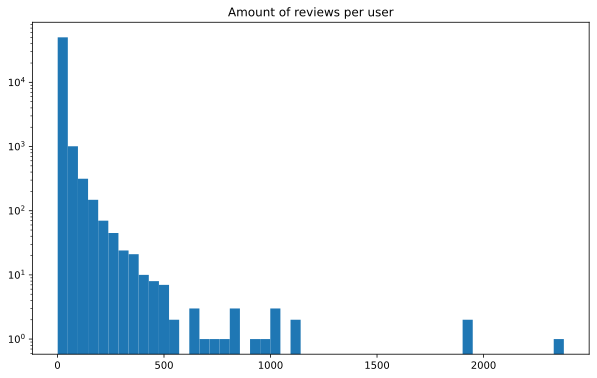

In [7]:
plt.hist(reviews.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [8]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(reviews, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(232467, 225151, 9640)

In [9]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(151566, 55577, 5789)

In [10]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

## Popular

In [11]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [12]:
topn = 20

In [13]:
alphas = [2 ** p for p in range(9)]

alpha2score = {}

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    alpha2score[a] = model_evaluate(popular_recs, holdoutval, data_description, topn)

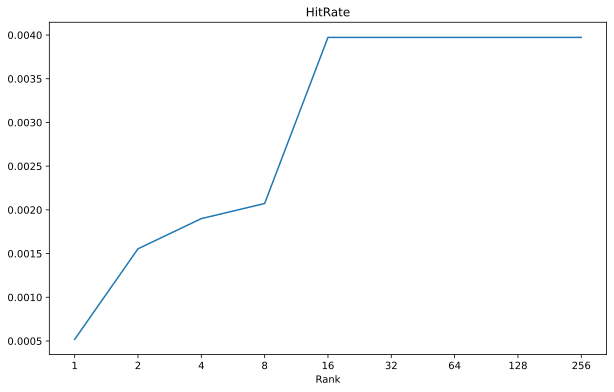

In [14]:
plt.plot(alphas, alpha2score.values())
plt.xscale("log")
plt.xticks(alphas, alphas)
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

## Pure SVD

In [15]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "items": "itemid",
    "users": "userid",
}

In [16]:
ranks = [b * 2 ** p for p in range(0, 9) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384, 512, 768]

In [17]:
results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn=20)

(32287, 25495)
0.00017608790128041966


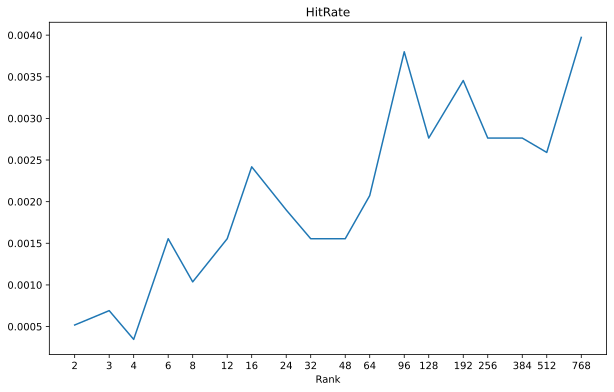

In [18]:
plt.plot(ranks, results.values())
plt.xscale("log")
plt.xticks(ranks, ranks)
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()